## sgdr

In [1]:
from tensorflow import keras
print(keras.__version__)

#熱重啟
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.backend as K
import numpy as np

class SGDRScheduler(Callback):

    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

2.4.0


## Grad-CAM

In [2]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

## build model

In [4]:
from tensorflow.keras.layers import BatchNormalization
import os
import json
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

INPUT_SIZE = 128
batch_size = 32

vgg19 = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(INPUT_SIZE,INPUT_SIZE,3)
)

gap = layers.GlobalMaxPooling2D()(vgg19.output)
drop1 = layers.Dropout(0.1)(gap)
#batch = BatchNormalization()(drop1)
#drop2 = layers.Dropout(0.1)(batch)
output = layers.Dense(1, activation='sigmoid',name='old_dense')(drop1)

# bind all
model = tf.keras.Model(vgg19.input, output)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)      

Found 1941 images belonging to 2 classes.
Found 831 images belonging to 2 classes.


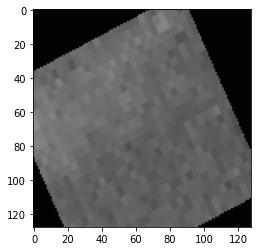

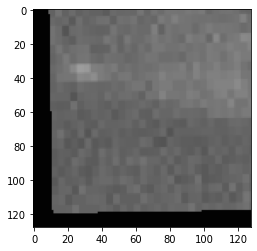

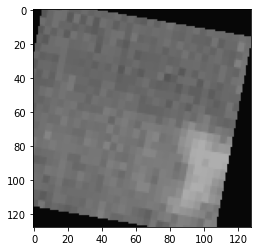

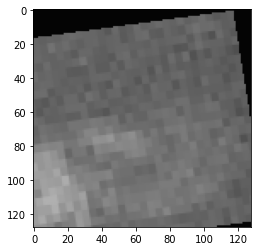

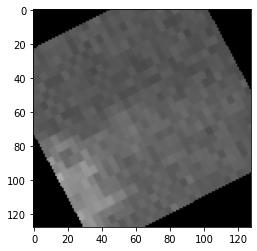

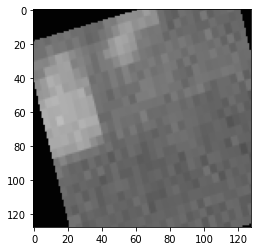

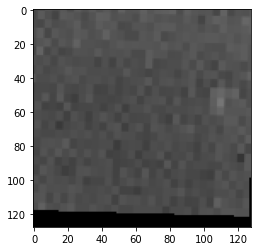

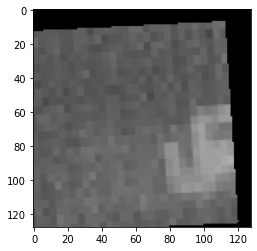

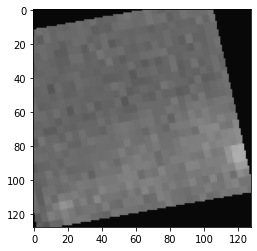

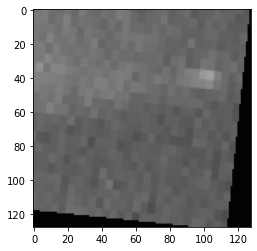

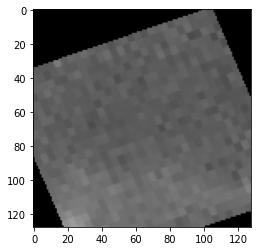

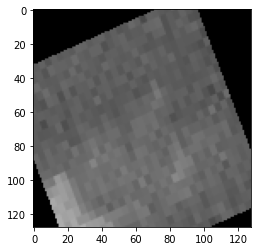

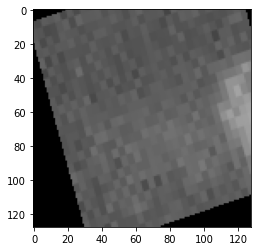

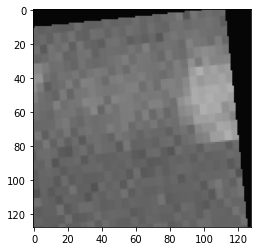

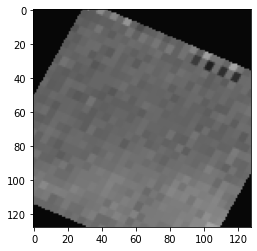

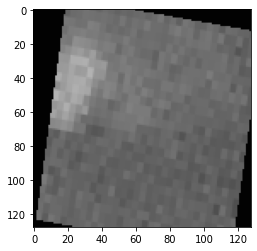

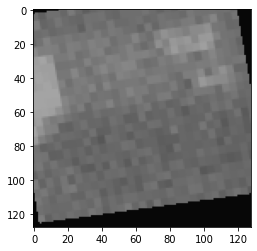

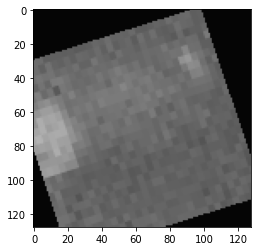

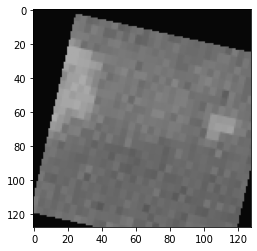

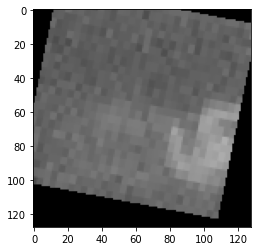

In [5]:
import matplotlib.pyplot as plt

target_size = (INPUT_SIZE,INPUT_SIZE)
directory = r"D:\Dementia_Data_Preprocessing\training_data\new"

image_generator = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 30,
                                   #zca_whitening=True,
                                   shear_range = 0.2,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   channel_shift_range = 10,
                                   fill_mode = 'constant',
                                   cval = 0,
                                   validation_split=0.3)    



training_set = image_generator.flow_from_directory(batch_size=batch_size,
                                                 directory=directory,
                                                 shuffle=True,
                                                 target_size= target_size, 
                                                 subset="training",
                                                 class_mode='binary')

valid_set = image_generator.flow_from_directory(batch_size=batch_size,
                                                 directory=directory,
                                                 shuffle=True,
                                                 target_size= target_size, 
                                                 subset="validation",
                                                 class_mode='binary')


train_num = training_set.samples
valid_num = valid_set.samples


for _ in range(20):
    img, label = training_set.next()
    plt.imshow(img[0])
    plt.show()

In [7]:
sgdr = SGDRScheduler( min_lr=1e-5,
                      max_lr=1e-2,
                      steps_per_epoch=np.ceil(train_num/batch_size),
                      lr_decay=0.9,
                      cycle_length=5,
                      mult_factor=1.5)

In [8]:
# early stopping
from tensorflow.keras.callbacks import EarlyStopping
patience=25
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

In [9]:
# checkpoint
filepath = "C:\\Users\\ee527\\Dementia_Vision_beta\\model\\tf22\\{epoch:02d}_{val_acc:.7f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,
mode='max')
callbacks_list = [checkpoint]

In [10]:
from tensorflow.keras import optimizers


model.compile(optimizer='SGD',
              loss='binary_crossentropy',  
              metrics=['acc']) 

epochs = 20

callbacks_list = [checkpoint,sgdr]

history0 = model.fit_generator(training_set,
                    steps_per_epoch=train_num//batch_size,
                    validation_data=valid_set,
                    epochs=epochs,
                    validation_steps=valid_num//batch_size,
                    callbacks=callbacks_list)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
  5/847 [..............................] - ETA: 45:48 - loss: 0.8076 - acc: 0.5375

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

acc = history0.history['acc']
val_acc = history0.history['val_acc']
loss = history0.history['loss']
val_loss = history0.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## heat map

In [ ]:
model_path = r'C:\Users\ee527\Dementia_Vision_beta\model\test.h5'

# D:\Dementia_Data_Preprocessing\main\label_image\4\20210819_t050450.jpg
test_img = r"D:\Dementia_Data_Preprocessing\main\label_image\2\20210819_t192239.jpg"


image = cv2.imread(test_img)
INPUT_SIZE = 128
image = cv2.resize(image, (INPUT_SIZE,INPUT_SIZE))
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)
model = tf.keras.models.load_model(model_path)
preds = model.predict(image) 
print(preds[0][0])

if preds[0][0]>0.5:
    label = 1
else:
    label = 0
    
print(label)

In [ ]:
# see all layer
for idx in range(len(model.layers)):
    print(model.get_layer(index = idx).name)

In [ ]:
# visualization
fig, ax = plt.subplots(1, 3)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)

plt.show()